In [1]:
#analysis
import glob
import os, sys
current_dir = os.path.dirname(os.path.realpath('__file__'))
os.path.abspath(os.getcwd())
sys.path.append("C:\\Users\\abel_\\Documents\\Rotations\\CIT")
sys.path.append('C:\\Users\\abel_\\Documents\\Rotations\\CIT\\cit_for_computation')
sys.path.append('C:\\Users\\abel_\\Documents\\Rotations\\CIT\\Conley')

import torch
import torch.nn as nn
import torch.optim as optim
# import torch.nn.init as weight_init

from netgraph import Graph #better for drawing graphs?
import networkx as nx
import subprocess
import scipy
from scipy.optimize import minimize
from scipy.stats import qmc

from functools import partial
import numpy as np
import numpy.ma as ma
import pickle
import re
import time
from tqdm.notebook import tqdm
from IPython.display import display, Math

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.markers as markers
import sklearn
import sklearn.decomposition

from typing import Sequence
import glob
import os, sys
import conley_functions as cf

def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

from utils import *
from analysis_functions import *
current_dir = 'C:\\Users\\abel_\\Documents\\Rotations\\CIT\cit_for_computation'

C:\Users\abel_\anaconda3\envs\CIT\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#load test data
with open("C:\\Users\\abel_\\Documents\\Rotations\\CIT\\experiments\\lr_clicks.pickle", 'rb') as handle:
    data_set = pickle.load(handle)
test_x, y, output_mask, trial_params = data_set

In [3]:
# plt.figure(figsize=(6,4))
# ax = plt.subplot(111)

exp_n = 7
Nrec = exp_n
N=Nrec

cmg_folder = current_dir+"\\experiments\\poisson_clicks\\CMG"
exp_folder = cmg_folder + "\\N%s\\"%exp_n
exp_list = glob.glob(exp_folder+"exp*")

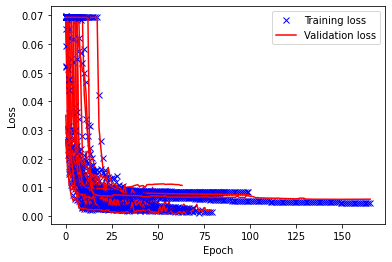

In [4]:
for exp_path in exp_list:

    idx = exp_path[-10:]
    with open(exp_path + '\\training_kwargs.pickle', 'rb') as handle:
        training_kwargs = pickle.load(handle)

    training_kwargs['exp_path'] = exp_path
    training_kwargs['training_weights_path'] = exp_path+'/training/'
    training_kwargs['figures_path'] = exp_path + '//figures/'

    idx = int(re.search(r'\d+', exp_path).group())

    rnn_model = RNNModel(training_kwargs['N_in'], training_kwargs['N_out'], training_kwargs['N_rec'], n_layers=1, transform_function='relu').to(device)
    rnn_model = load_model(rnn_model, training_kwargs)
    rnn_model.eval();
    
    with open(training_kwargs['exp_path'] + '/learning_info.pickle', 'rb') as handle:
        learning_info = pickle.load(handle)
    epoch_counter = 0
    losses = learning_info['training_loss']
    plt.plot(range(epoch_counter, epoch_counter+len(losses)), losses, 'bx', label="Training loss")
    val_losses = learning_info['validation_loss']
    plt.plot(range(epoch_counter, epoch_counter+len(losses)), val_losses, 'r', label="Validation loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(['Training loss', 'Validation loss'])
    #plt.savefig(training_kwargs['figures_path'] + '/losses_opt'+training_kwargs['optimizer']+'lr'+str(training_kwargs['learning_rate'])+'.pdf')
plt.savefig(exp_folder+'/all_losses.pdf')

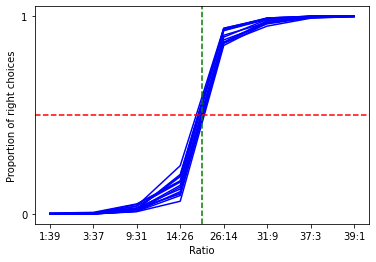

In [108]:
plt.figure(figsize=(6,4))
ax = plt.subplot(111)
accurate_counter = 0
accuracy_list = []
for exp_path in exp_list:

    idx = exp_path[-10:]
    with open(exp_path + '\\training_kwargs.pickle', 'rb') as handle:
        training_kwargs = pickle.load(handle)

    training_kwargs['exp_path'] = exp_path
    training_kwargs['training_weights_path'] = exp_path+'/training/'
    training_kwargs['figures_path'] = exp_path + '//figures/'
    
    rnn_model = RNNModel(training_kwargs['N_in'], training_kwargs['N_out'], training_kwargs['N_rec'], n_layers=1, transform_function='relu').to(device)
    rnn_model = load_model(rnn_model, training_kwargs)
    rnn_model.eval();

    inputs = torch.tensor(test_x, dtype=torch.float)
    yhat, hidden = rnn_model(inputs)
    yhat = yhat.detach().numpy()

    accuracy, response_correctness, choice_proportion_per_ratio, average_accuracy_per_ratio, N_clicks, highest_click_count_index = get_accuracy_poissonclicks(test_x, yhat, output_mask, trial_params)    
    
    if accuracy>0.95:
        accuracy_list.append(accuracy)
        ax.plot(1-choice_proportion_per_ratio, 'b')
        accurate_counter += 1 

coherence_labels=['1:39', '3:37', '9:31', '14:26', '26:14', '31:9', '37:3', '39:1']
ax.set_xticks(range(len(coherence_labels)), coherence_labels);
ax.set_xlabel("Ratio")
ax.set_ylabel("Proportion of right choices")
ax.set_yticks([0,1])
ax.axhline(y = 0.5, color = 'r', linestyle = '--')
ax.axvline(x = 3.5, color = 'g', linestyle = '--')
plt.savefig(exp_folder+"all_psycho.pdf")

np.savetxt(exp_folder + "\\all_accuracies.txt", accuracy_list)

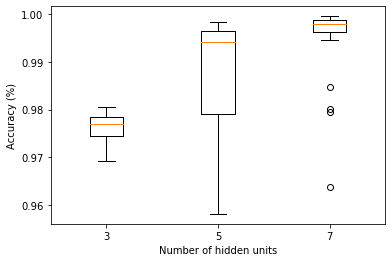

In [111]:
#Accuracy
data = []
# order of duration data: disc_durations rc_durations ipci_durations
dur_i = 2
for N_i, Nrec in enumerate([3,5,7]):
    exp_folder = cmg_folder+"\\N%s\\"%Nrec
    accuracy_list = np.loadtxt(exp_folder + "\\all_accuracies.txt")
    data.append(accuracy_list)
plt.boxplot(data); 
plt.xticks(range(1,4),[3,5,7])
plt.xlabel("Number of hidden units")
plt.ylabel("Accuracy (%)");
plt.savefig(cmg_folder + "\\all_accuracies_box.pdf")

## Fixed points

In [5]:
weights_dict = {key: rnn_model.state_dict()[key].numpy() for key in rnn_model.state_dict().keys()}

W_ih = weights_dict['rnn.weight_ih_l0'] 
b_in = weights_dict['rnn.bias_ih_l0']
W_hh = rnn_model.state_dict()['rnn.weight_hh_l0'] #['rnn.weight_ih_l0']
b_h = weights_dict['rnn.bias_hh_l0']
W_ho = rnn_model.state_dict()['fc.weight'] 
b = b_in + b_h

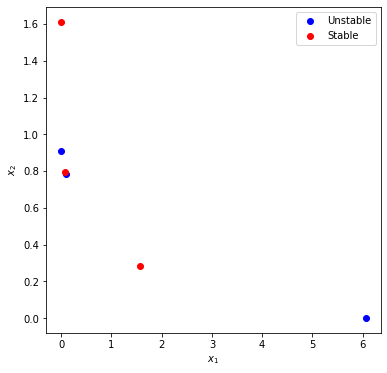

In [6]:
I = [0.,0.]
tol=10**-3
fixed_points, stabilist, unstabledimensions = find_analytic_fixed_points(W_hh, b, W_ih, I, tol=tol)
colorlist = np.array(['b', 'r'])
labellist = np.array(['Unstable', 'Stable'])
stabilist = np.array(stabilist)
fixed_points =  np.array(fixed_points)
number_of_fixed_points = fixed_points.shape[0]
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
for st in np.unique(stabilist):
    idx = np.where(st==stabilist, True, False)
    sc = plt.scatter(fixed_points[idx,0], fixed_points[idx,1], color=colorlist[st], label=labellist[st])
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.legend();
plt.savefig(training_kwargs['figures_path'] + "\\analytical_fixedpoints_I(%s,%s).pdf"%(I[0],I[1]))

### Morse decomposition

In [5]:
colorlist = np.array(['b', 'r'])
labellist = np.array(['Unstable', 'Stable'])

I = [0.,0.] #no input
tol=10**-3

maxT = 5000

#grid size:
expnbin = 4
nbins = 2**expnbin
delta = 1/nbins

minval = 0

In [ ]:
cmg_class_dict = {0:[np.array([]),[]]} #key: class, value:list of [connection_matrix, all_eigenvalue_dicts]
cmg_amount_dict = {0:0}

disc_durations = []
rc_durations = []
ipci_durations = []
all_durations = []

number_of_fxdpnt_list = []
fxdpnt_list = [] 
stabilities_list = []
connection_list = []
rc_eigenvalues_list = []
for exp_path in exp_list[-1:]:
    morse_dict = {}

    idx = exp_path[-10:]
    with open(exp_path + '\\training_kwargs.pickle', 'rb') as handle:
        training_kwargs = pickle.load(handle)

    training_kwargs['exp_path'] = exp_path
    training_kwargs['training_weights_path'] = exp_path+'/training/'
    training_kwargs['figures_path'] = exp_path + '//figures/'
    
    #load model
    rnn_model = RNNModel(training_kwargs['N_in'], training_kwargs['N_out'], training_kwargs['N_rec'], n_layers=1, transform_function='relu').to(device)
    rnn_model = load_model(rnn_model, training_kwargs)
    rnn_model.eval();
    
    #get weights and biases
    weights_dict = {key: rnn_model.state_dict()[key].numpy() for key in rnn_model.state_dict().keys()}
    W_ih = weights_dict['rnn.weight_ih_l0'] 
    b_in = weights_dict['rnn.bias_ih_l0']
    W_hh = rnn_model.state_dict()['rnn.weight_hh_l0'] #['rnn.weight_ih_l0']
    b_h = weights_dict['rnn.bias_hh_l0']
    W_ho = rnn_model.state_dict()['fc.weight'] 
    b = b_in + b_h
    
    #find fixed points
    fixed_points, stabilist, unstabledimensions = find_analytic_fixed_points(W_hh, b, W_ih, I, tol=tol)
    
    stabilist = np.array(stabilist)
    fixed_points =  np.array(fixed_points)
    unstabledimensions = np.array(unstabledimensions)
    number_of_fixed_points = fixed_points.shape[0]
    number_of_fxdpnt_list.append(number_of_fixed_points)
    
    if number_of_fixed_points==0:
        
        sampler = qmc.Sobol(d=Nrec, scramble=False)         # sobol sequence as grid
        grid = sampler.random_base2(m=8) # random_base2: safely draw  points. This method guarantees the balance properties of the sequence.
        grid = grid.reshape((1, -1, Nrec))
        hidden = torch.tensor(grid, dtype=torch.float)
        hidden_states = sample_hidden_trajs(rnn_model, hidden, maxT)
        all_hidden_t = np.transpose(hidden_states, axes=(1,0,2))
        
        maxval = np.max(all_hidden_t)

        #attracting recurrent sets
        cds = cf.Combinatorial_Dynamical_System(delta)
        cds.get_cubesandgraph(all_hidden_t[int(0.8*maxT):,:,:], nbins, calc_matrix=True, minval=minval, maxval=maxval)
        RCs = cds.get_recurrent_components(includeselfedges=False)
        
        if len(RCs) == 0:
            print("N_fxdpnts = ", number_of_fixed_points, "No other RCs")
            morse_dict['fixed_points'] = []
            morse_dict['stabilities_list'] = []
            morse_dict['number_of_fixed_points'] = 0
            morse_dict['connection_matrix'] = []
            morse_dict['rcs'] = []
            cmg_amount_dict[0] += 1
            print(cmg_amount_dict)
            with open(exp_path + "\\morse_dict.pickle", 'wb') as handle:
                pickle.dump(morse_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
                
            continue
            
        #for this possibility the eigenvalues of the RCs should be calculated!
        morse_dict['fixed_points'] = []
        morse_dict['stabilities_list'] = []
        morse_dict['number_of_fixed_points'] = 0
        morse_dict['connection_matrix'] = np.zeros((len(RCs), len(RCs)))
        morse_dict['rcs'] = RCs
        
        oldclass = False
        for i, [connection_matrix, rc_eigenvalues] in enumerate(cmg_class_dict.values()):
            print(connection_matrix)
            if np.all(connection_matrix==np.zeros((len(RCs), len(RCs)))):
                cmg_amount_dict[i] += 1
                oldclass = True
                break
                
        if not oldclass:
            number_of_existing_classes = len(list(cmg_amount_dict.values()))
            cmg_class_dict[number_of_existing_classes] = [[], np.zeros((len(RCs), len(RCs)))]
            cmg_amount_dict[number_of_existing_classes] = 1
        
        print(cmg_class_dict, cmg_amount_dict)
            
        with open(exp_path + "\\morse_dict.pickle", 'wb') as handle:
            pickle.dump(morse_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

        fxdpnt_list.append(fixed_points)
        stabilities_list.append(stabilities)
        connection_list.append(connection_matrix)
        print("N_fxdpnts = ", number_of_fixed_points, "N_other = ", len(RCs))
        continue
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    for st in np.unique(stabilist):
        idx = np.where(st==stabilist, True, False)
        sc = plt.scatter(fixed_points[idx,0], fixed_points[idx,1], color=colorlist[st], label=labellist[st])
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.legend();
    plt.savefig(training_kwargs['figures_path'] + "\\analytical_fixedpoints_noinput.pdf")
    plt.close()
    
    #order fixed points based on stability: first stable, then unstable
    fxd_ordering = []
    for fxdi, fxd in enumerate(fixed_points):
        if stabilist[fxdi] == 0: #i.e. fixed point is unstable
            fxd_ordering.append(fxdi)
        else:
            fxd_ordering.insert(0, fxdi)
    fixed_points = fixed_points[fxd_ordering]
    stabilist = stabilist[fxd_ordering]
    unstabledimensions = unstabledimensions[fxd_ordering]
    
    #sample trajectories starting at grid points
    sampler = qmc.Sobol(d=Nrec, scramble=False)         # sobol sequence as grid
    grid = sampler.random_base2(m=8) # random_base2: safely draw  points. This method guarantees the balance properties of the sequence.
    grid = grid.reshape((1, -1, Nrec))
    hidden = torch.tensor(grid, dtype=torch.float)
    hidden_states = sample_hidden_trajs(rnn_model, hidden, maxT=maxT)
    
    #sample trajectories starting around the unstable fixed points to determine connecting orbits 
    # should be enough to do this around unstable fixed points if stable fxd pnts are really stable
    
    #calculate maximal distance for grid around all fixed points
    distances = np.zeros((number_of_fixed_points, number_of_fixed_points))
    for i1, p1 in enumerate(fixed_points):
        save_point = True
        for i2, p2 in enumerate(fixed_points):
            distances[i1, i2] = np.linalg.norm(p1-p2)
    min_distance_fxdpnts = np.min(np.where(distances>0., distances, 0.1))/3.
    
    unstable_fxdpnts = fixed_points[np.where(stabilist==0.)]
    all_hidden_stack, grid = sample_trajs_fxdpnts(rnn_model, Nrec, unstable_fxdpnts, max_grid=min_distance_fxdpnts, Nsteps = 3, maxT=maxT)
    #stack trajectories from to samples: grid and fixed points
    all_hidden_stack = np.concatenate([all_hidden_stack, hidden_states])
    all_hidden_t = np.transpose(all_hidden_stack, axes=(1,0,2))
    
    #calculate recurrent sets: 
    maxval = np.max(all_hidden_stack)
    
    #get cubes of fixed points:
    # cds_fxd = cf.Combinatorial_Dynamical_System(delta)
    # cds_fxd.get_cubesandgraph(all_hidden_t[0:2,:,:], nbins, calc_matrix=True, minval=minval, maxval=maxval)
    # RCs_fxd = cds_fxd.get_recurrent_components(includeselfedges=True)
    # if number_of_fixed_points!=len(RCs_fxd):
    #     print("Fixed point anomaly")

    #attracting recurrent sets
    # cds = cf.Combinatorial_Dynamical_System(delta)
    # cds.get_cubesandgraph(all_hidden_t[int(0.8*maxT):,:,:], nbins, calc_matrix=True, minval=minval, maxval=maxval)
    
    #make full multivalued map
    start_time = time.time()
    cds_full = cf.Combinatorial_Dynamical_System(delta)
    cds_full.get_cubesandgraph(all_hidden_t, nbins, calc_matrix=True, minval=minval, maxval=maxval)
    duration = time.time()-start_time
    disc_durations.append(duration)
    
    start_time = time.time()
    RCs = cds_full.get_recurrent_components(includeselfedges=False)
    duration = time.time()-start_time
    rc_durations.append(duration)

    
    #get connectoin matrix
    fixed_point_cubes = []
    bins = np.linspace(0, maxval, nbins)
    digitized = np.digitize(fixed_points, bins)
    for fxdi in range(number_of_fixed_points):
        fxd_bin = tuple(list(digitized[fxdi,  :]))
        fixed_point_cubes.append(fxd_bin)
    connection_matrix, order_idx = get_connection_matrix(fixed_point_cubes, RCs, cds_full)
    
    fixed_points = fixed_points[order_idx[len(RCs):]-len(RCs),:]
    stabilities = stabilist[order_idx[len(RCs):]-len(RCs)]
    
    
    #make dir for conley
    conley_path = exp_path + r"\conley_info"
    makedirs(conley_path)
    %cd "$conley_path"

    #time index pair + Conley index:
    start_time = time.time()
    get_indexpair_and_conleyindex(cds_full, RCs)
    duration = time.time() - start_time
    ipci_durations.append(duration)
    
    all_rc_eigenvalues = []
    all_betti = []
    all_eigenvalue_dicts = [] #list of dicts one dict for each rc, the dict contains all the (nonzero) homology levels
    if len(RCs)>0:
        log_list = glob.glob(conley_path+"\\*.log")
        # print(log_list)
        for log_name in log_list:
            eigenvalue_dict = {}
            rci_eigenvalues = []
            rci_betti = []
            created_A = False
            # log_name = log_list[0]
            i=0
            with open(log_name) as file:
                lines = file.readlines()
                lines = [line.rstrip() for line in lines if len(line.rstrip())>0]
                for line_i, line in enumerate(lines):
                    # print(line)
                    if line.startswith("H_"):
                        # print(line)
                        level = line[2]
                        if line[-1]=="Z":
                            betti = 1
                        else:
                            betti = int(line[-1])
                        if lines[line_i-1]=="C":
                            rci_betti.append(betti)
                        A = np.zeros((betti, betti))
                        created_A = True
                    if (line.startswith("Dim")) or line.startswith("\tF"):
                        if "\tF" not in line: 
                            continue
                        i+=1
                        # print(i, line)
                        equation_right = line.split('=')[-1]
                        image_strings = equation_right.split('x')[1:]
                        # print(image_strings)
                        for j,image_index in enumerate(image_strings):
                            A[i-1,int(image_index)-1] = 1
                if created_A:
                    print(A)
                    rci_hn_eigenvalues = np.linalg.eigvals(A)
                    rci_eigenvalues.append(rci_hn_eigenvalues)
                    eigenvalue_dict[level] = rci_hn_eigenvalues
            all_betti.append(rci_betti)
            all_rc_eigenvalues.append(rci_eigenvalues)
            all_eigenvalue_dicts.append(eigenvalue_dict)
        # #first:    homology of the graph of F over the ring of integers        
        # # second:  homology of Y over the ring of integers 
    else: 
        eigenvalue_dict = {}
    
    #save
    all_durations.append([disc_durations[-1], rc_durations[-1], ipci_durations[-1]])
    morse_dict['fixed_points'] = fixed_points
    morse_dict['stabilities_list'] = stabilities
    morse_dict['unstabledimensions'] = unstabledimensions
    morse_dict['number_of_fixed_points'] = number_of_fixed_points
    morse_dict['connection_matrix'] = connection_matrix
    morse_dict['all_rc_eigenvalues'] = all_rc_eigenvalues
    morse_dict['all_eigenvalue_dicts'] = all_eigenvalue_dicts
    morse_dict['all_betti'] = all_betti
    morse_dict['eigenvalue_dict'] = eigenvalue_dict
    morse_dict['rcs'] = RCs
    morse_dict['all_durations'] = np.array([disc_durations[-1], rc_durations[-1], ipci_durations[-1]])
    
    
    for i, [connection_matrix, all_eigenvalue_dicts] in enumerate(cmg_class_dict.values()):
        oldclass = True
        if np.all(connection_matrix.shape == morse_dict['connection_matrix'].shape):
            isom = find_graph_isomorphism(connection_matrix, morse_dict)
            if np.all(isom!=False):
                for rci, rc_eigenvalue in enumerate(morse_dict['all_eigenvalue_dicts']): #iterate over all RCs
                    for level in rc_eigenvalue.keys(): #iterate over all homology levels
                        if all_eigenvalue_dicts[isom][rci][level] == rc_eigenvalue[level]:
                            0
                        else:
                            oldclass = False
                            break
        else:
            oldclass = False
        if oldclass: #if the same CMGraph is found (isomorphic connection matrice and none of the eigenvalues was different) break loop and add to class amount dictionary
            cmg_amount_dict[i] += 1
            break

    if not oldclass:
        number_of_existing_classes = len(list(cmg_amount_dict.values()))
        cmg_class_dict[number_of_existing_classes] = [morse_dict['connection_matrix'], morse_dict['all_rc_eigenvalues']]
        cmg_amount_dict[number_of_existing_classes] = 1
        
    print(cmg_class_dict, cmg_amount_dict)
    
    with open(exp_path + "\\morse_dict.pickle", 'wb') as handle:
        pickle.dump(morse_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    fxdpnt_list.append(fixed_points)
    stabilities_list.append(stabilities)
    connection_list.append(connection_matrix)
    rc_eigenvalues_list.append(all_rc_eigenvalues)
    
    print("N_fxdpnts = ", number_of_fixed_points, "N_other = ", len(RCs))
    if len(RCs)>0:
        print("\tEigenvalues:", morse_dict['all_rc_eigenvalues'])
        
# np.savetxt(exp_folder + "\\all_durations.txt", all_durations)

# with open(exp_folder + "\\cmg_class_dict.pickle", 'wb') as handle:
#     pickle.dump(cmg_class_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# with open(exp_folder + "\\cmg_amount_dict.pickle", 'wb') as handle:
#     pickle.dump(cmg_amount_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
morse_dict

### Plot all CMGraphs

C:\Users\abel_\Documents\Rotations\CIT\cit_for_computation\experiments\poisson_clicks\CMG\N7\exp_20_Nrec7_idx0_1658250891
RCS:  3 1
[{'0': array([ 1., -1.])}, {5: array([1.])}, {3: array([1.])}, {4: array([1.])}]
C:\Users\abel_\Documents\Rotations\CIT\cit_for_computation\experiments\poisson_clicks\CMG\N7\exp_20_Nrec7_idx0_1658253424
RCS:  2 0
[{}, {3: array([1.])}, {3: array([1.])}]
C:\Users\abel_\Documents\Rotations\CIT\cit_for_computation\experiments\poisson_clicks\CMG\N7\exp_20_Nrec7_idx0_1658254935
RCS:  5 0
[{}, {4: array([1.])}, {3: array([1.])}, {3: array([1.])}, {4: array([1.])}, {4: array([1.])}]
C:\Users\abel_\Documents\Rotations\CIT\cit_for_computation\experiments\poisson_clicks\CMG\N7\exp_20_Nrec7_idx0_1658261229
RCS:  5 0
[{}, {5: array([1.])}, {5: array([1.])}, {3: array([1.])}, {3: array([1.])}, {5: array([1.])}]
C:\Users\abel_\Documents\Rotations\CIT\cit_for_computation\experiments\poisson_clicks\CMG\N7\exp_20_Nrec7_idx0_1658261838
RCS:  7 0
[{}, {4: array([1.])}, {4: a

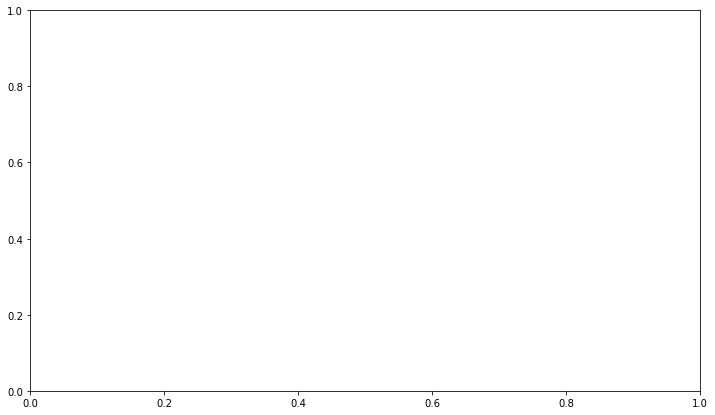

In [116]:
colorlist = ['r', 'mediumblue', 'g']
for exp_path in exp_list[-1:]:
        print(exp_path)
        fig, ax = plt.subplots(figsize=(12,7))
        # ax.set_title('Title for NetworkX', loc='right')
    # try:
        with open(exp_path + '\\training_kwargs.pickle', 'rb') as handle:
            training_kwargs = pickle.load(handle)
            training_kwargs['exp_path'] = exp_path
            training_kwargs['training_weights_path'] = exp_path+'/training/'
            training_kwargs['figures_path'] = exp_path + '//figures/'
        
        with open(exp_path + "\\morse_dict.pickle", 'rb') as handle:
            morse_dict = pickle.load(handle)
        connection_matrix = morse_dict['connection_matrix']
        number_of_fixed_points = morse_dict['number_of_fixed_points']
        RCs = morse_dict['rcs']
        sum_of_outgoing_trajectories = np.sum(connection_matrix, axis=0)
        order_idx = np.argsort(sum_of_outgoing_trajectories)
        
        if number_of_fixed_points==0:
            continue
            
        print("RCS: ", number_of_fixed_points, len(RCs))
        
        node_color_idx = [0]*(len(RCs)+number_of_fixed_points)
        node_color_idx[-number_of_fixed_points:] = [colorlist[i] for i in morse_dict['stabilities_list']]
        node_color_idx[:len(RCs)] = [colorlist[-1]]*len(RCs)
        
        labels =  [morse_dict['eigenvalue_dict']]
        if len(list(morse_dict['eigenvalue_dict'].keys())) < len(RCs):
            for i in range(len(RCs)-len(list(morse_dict['eigenvalue_dict'].keys()))):
                labels.append({0:np.array([0])})
        unstabledimensions = morse_dict['unstabledimensions']
        for i in range(morse_dict['number_of_fixed_points']):
            level = unstabledimensions[i]
            labels.append({level:np.array([1.])})
        print(labels)
        
        labeldict = {key:"" for key in range(len(RCs) + number_of_fixed_points)}
        for rci in range(len(RCs) + number_of_fixed_points):
            # print(rci)
            for j in range(len(list(labels[rci].keys()))):
                # print("M(%s): "%rci + str(list(labels[rci].keys())[j]) + '\u2192' + str(list(list(labels[rci].values())[0].astype(int))))
                labeldict[rci] += "M(%s):"%rci + str(list(labels[rci].keys())[j]) + '\u2192' + str(list(list(labels[rci].values())[0].astype(int)))

        # print(labeldict, node_color_idx)    
            
        layers = list(np.unique(sum_of_outgoing_trajectories).astype(int))
        G = nx.DiGraph()
        for (i, layer) in enumerate(layers):
            idx = np.where(sum_of_outgoing_trajectories == layer)[0]
            for j in idx:
                G.add_nodes_from([j], layer=i, label=j)
        for i in range(len(RCs)+number_of_fixed_points):
            edges = [(i,j) for j in np.where(connection_matrix[:,i]!=0.)[0]]
            G.add_edges_from(edges)
        pos = nx.multipartite_layout(G, subset_key="layer", align='horizontal')
        # pos = {key:pos[key][::-1] for key in pos.keys()}
        # bbox_list = [dict(facecolor=node_color_idx[i], edgecolor='black', boxstyle='round,pad=0.2') for i in range(len(node_color_idx))]
        # nx.draw(G, pos, node_color=node_color_idx, with_labels=True, labels=labeldict, node_shape="s", node_size=500)
        # nx.draw(G, pos, node_color=node_color_idx, with_labels=True, labels=labeldict, node_shape="s", bbox=dict(facecolor='skyblue', edgecolor='black', boxstyle='round,pad=0.2'))
        for i in range(len(RCs)+number_of_fixed_points):
            # print(i)
            subpos = {k:pos[k] for k in [i]}
            nx.draw(G.subgraph([i]), subpos, ax=ax, node_color='none', with_labels=True, labels={i:labeldict[i]}, node_shape="s", bbox=dict(facecolor=node_color_idx[i], edgecolor='black', boxstyle='round,pad=0.2'))

            for j in range(i, len(RCs)+number_of_fixed_points):
                if i!=j:
                    H = G.subgraph([i,j])
                    subpos = {k:pos[k] for k in [i,j]}
                    sublabels = {k:labeldict[k] for k in [i,j]}
                    nx.draw(H, subpos, node_color='none', with_labels=False, node_size=1000)

        # ax.text(pos[number_of_fixed_points][0], pos[number_of_fixed_points][1], 'Unstable', color='mediumblue')
        # ax.text(pos[number_of_fixed_points][0], pos[number_of_fixed_points][1]-.1, 'Stable', color='red')

        plt.margins(.15)

        plt.savefig(training_kwargs['figures_path'] + "\\MorseGraph.pdf")
        plt.close()
        # print(training_kwargs['figures_path'])
    # except:
    #     0

### Compare all CM-graphs

In [51]:
cmg_class_dict = {0:[np.array([]),[]]} #key: class, value:list of [connection_matrix, all_eigenvalue_dicts]
cmg_amount_dict = {0:[0,0,0]} #dictionary: key=class, value=list of amounts per Nrec
cmg_file_dict = {0:[]} #dictionary for the file paths for the different CMG classes: list of files (values) for each class (key)


for N_i, Nrec in enumerate([3,5,7]):
    exp_folder = cmg_folder+"\\N%s\\"%Nrec
    print(exp_folder)
    exp_list = glob.glob(exp_folder+"exp*")
    for exp_path in exp_list[:]:
        print(exp_path)
        
        with open(exp_path + "\\morse_dict.pickle", 'rb') as handle:
            morse_dict = pickle.load(handle)
            
        connection_matrix = morse_dict['connection_matrix']
        number_of_fixed_points = morse_dict['number_of_fixed_points']
        RCs = morse_dict['rcs']
            
        # print(number_of_fixed_points, len(RCs))
        if number_of_fixed_points==0:
            if len(RCs) == 0:
                cmg_amount_dict[0][N_i] += 1
                cmg_file_dict[0].append(exp_path)
            
            else:
                oldclass = False
                for i, [connection_matrix, rc_eigenvalues] in enumerate(cmg_class_dict.values()):
                    print(connection_matrix)
                    if np.all(connection_matrix==np.zeros((len(RCs), len(RCs)))):
                        cmg_amount_dict[i][N_i] += 1
                        cmg_file_dict[i].append(exp_path)
                        oldclass = True
                        break

                if not oldclass:
                    number_of_existing_classes = len(list(cmg_amount_dict.values()))
                    cmg_class_dict[number_of_existing_classes] = [[], np.zeros((len(RCs), len(RCs)))]
                    cmg_amount_dict[number_of_existing_classes] = [0,0,0]
                    cmg_amount_dict[number_of_existing_classes][N_i] = 1
                    cmg_file_dict[number_of_existing_classes] = [exp_path]
        else:
            for i, [connection_matrix, all_eigenvalue_dicts] in enumerate(cmg_class_dict.values()):
                oldclass = True
                if np.all(connection_matrix.shape == morse_dict['connection_matrix'].shape):
                    isom = find_graph_isomorphism(connection_matrix, morse_dict)
                    if np.all(isom!=False):
                        for rci, rc_eigenvalue in enumerate(morse_dict['all_eigenvalue_dicts']): #iterate over all RCs
                            for level in rc_eigenvalue.keys(): #iterate over all homology levels
                                if all_eigenvalue_dicts[isom][rci][level] == rc_eigenvalue[level]:
                                    0
                                else:
                                    oldclass = False
                                    break
                else:
                    oldclass = False
                if oldclass: #if the same CMGraph is found (isomorphic connection matrice and none of the eigenvalues was different) break loop and add to class amount dictionary
                    cmg_amount_dict[i][N_i] += 1
                    cmg_file_dict[i].append(exp_path)
                    break

            if not oldclass:
                number_of_existing_classes = len(list(cmg_amount_dict.values()))
                cmg_class_dict[number_of_existing_classes] = [morse_dict['connection_matrix'], morse_dict['all_rc_eigenvalues']]
                cmg_amount_dict[number_of_existing_classes] = [0,0,0]
                cmg_amount_dict[number_of_existing_classes][N_i] = 1
                cmg_file_dict[number_of_existing_classes] = [exp_path]

C:\Users\abel_\Documents\Rotations\CIT\cit_for_computation\experiments\poisson_clicks\CMG\N3\
C:\Users\abel_\Documents\Rotations\CIT\cit_for_computation\experiments\poisson_clicks\CMG\N3\exp_Nrec3_idx0_1658237271
C:\Users\abel_\Documents\Rotations\CIT\cit_for_computation\experiments\poisson_clicks\CMG\N3\exp_Nrec3_idx0_1658238228
C:\Users\abel_\Documents\Rotations\CIT\cit_for_computation\experiments\poisson_clicks\CMG\N3\exp_Nrec3_idx0_1658242399
C:\Users\abel_\Documents\Rotations\CIT\cit_for_computation\experiments\poisson_clicks\CMG\N3\exp_Nrec3_idx0_1658244412
C:\Users\abel_\Documents\Rotations\CIT\cit_for_computation\experiments\poisson_clicks\CMG\N3\exp_Nrec3_idx0_1658245314
C:\Users\abel_\Documents\Rotations\CIT\cit_for_computation\experiments\poisson_clicks\CMG\N3\exp_Nrec3_idx1_1658237271
C:\Users\abel_\Documents\Rotations\CIT\cit_for_computation\experiments\poisson_clicks\CMG\N3\exp_Nrec3_idx1_1658238228
C:\Users\abel_\Documents\Rotations\CIT\cit_for_computation\experiments\po

In [52]:
with open(cmg_folder + "\\cmg_class_dict.pickle", 'wb') as handle:
    pickle.dump(cmg_class_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(cmg_folder + "\\cmg_amount_dict.pickle", 'wb') as handle:
    pickle.dump(cmg_amount_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(cmg_folder + "\\cmg_file_dict.pickle", 'wb') as handle:
    pickle.dump(cmg_file_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [53]:
cmg_class_dict

{0: [array([], dtype=float64), []],
 1: [array([[0.]]), []],
 2: [array([[0., 0., 1.],
         [0., 0., 1.],
         [0., 0., 0.]]),
  []],
 3: [array([[0., 0., 1., 1., 1.],
         [0., 0., 1., 1., 1.],
         [0., 0., 0., 1., 1.],
         [0., 0., 1., 0., 1.],
         [0., 0., 1., 1., 0.]]),
  [[array([1.])], [array([ 1., -1.])]]],
 4: [array([[0., 1.],
         [0., 0.]]),
  []],
 5: [array([[0., 0., 1., 1.],
         [0., 0., 0., 1.],
         [0., 0., 0., 1.],
         [0., 0., 0., 0.]]),
  [[array([ 1., -1.])]]],
 6: [array([[0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 1., 1., 1., 1., 1.],
         [0., 0., 0., 1., 1., 1., 1.],
         [0., 0., 1., 0., 1., 1., 1.],
         [0., 0., 0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 1., 0., 1.],
         [0., 0., 0., 0., 1., 1., 0.]]),
  []],
 7: [array([[0., 0., 0., 1., 1., 1.],
         [0., 0., 0., 1., 1., 1.],
         [0., 0., 0., 1., 1., 1.],
         [0., 0., 0., 0., 1., 1.],
         [0., 0., 0., 1., 0., 1.],
     

In [54]:
cmg_file_dict

{0: ['C:\\Users\\abel_\\Documents\\Rotations\\CIT\\cit_for_computation\\experiments\\poisson_clicks\\CMG\\N3\\exp_Nrec3_idx0_1658237271',
  'C:\\Users\\abel_\\Documents\\Rotations\\CIT\\cit_for_computation\\experiments\\poisson_clicks\\CMG\\N3\\exp_Nrec3_idx2_1658237271',
  'C:\\Users\\abel_\\Documents\\Rotations\\CIT\\cit_for_computation\\experiments\\poisson_clicks\\CMG\\N3\\exp_Nrec3_idx2_1658245314',
  'C:\\Users\\abel_\\Documents\\Rotations\\CIT\\cit_for_computation\\experiments\\poisson_clicks\\CMG\\N3\\exp_Nrec3_idx3_1658238228',
  'C:\\Users\\abel_\\Documents\\Rotations\\CIT\\cit_for_computation\\experiments\\poisson_clicks\\CMG\\N5\\exp_Nrec5_idx0_1658199095',
  'C:\\Users\\abel_\\Documents\\Rotations\\CIT\\cit_for_computation\\experiments\\poisson_clicks\\CMG\\N5\\exp_Nrec5_idx2_1658201435',
  'C:\\Users\\abel_\\Documents\\Rotations\\CIT\\cit_for_computation\\experiments\\poisson_clicks\\CMG\\N5\\exp_Nrec5_idx3_1658193186',
  'C:\\Users\\abel_\\Documents\\Rotations\\CIT\\cit_

In [55]:
cmg_amount_dict

{0: [4, 3, 1],
 1: [17, 9, 1],
 2: [2, 6, 4],
 3: [1, 1, 9],
 4: [1, 5, 2],
 5: [0, 1, 4],
 6: [0, 0, 1],
 7: [0, 0, 3]}

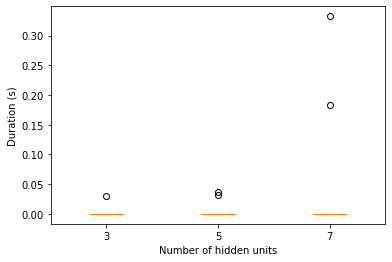

In [88]:
#TIME
data = []
# order of duration data: disc_durations rc_durations ipci_durations
dur_i = 2
for N_i, Nrec in enumerate([3,5,7]):
    exp_folder = cmg_folder+"\\N%s\\"%Nrec
    all_durations = np.loadtxt(exp_folder + "\\all_durations.txt")
    data.append(all_durations[:,dur_i][np.where(all_durations[:,dur_i]<500)])
plt.boxplot(data); 
plt.xticks(range(1,4),[3,5,7])
plt.xlabel("Number of hidden units")
plt.ylabel("Duration (s)");

In [58]:
exp_path = exp_list[-1]

idx = exp_path[-10:]
with open(exp_path + '\\training_kwargs.pickle', 'rb') as handle:
    training_kwargs = pickle.load(handle)

training_kwargs['exp_path'] = exp_path
training_kwargs['training_weights_path'] = exp_path+'/training/'
training_kwargs['figures_path'] = exp_path + '//figures/'

#load model
rnn_model = RNNModel(training_kwargs['N_in'], training_kwargs['N_out'], training_kwargs['N_rec'], n_layers=1, transform_function='relu').to(device)
rnn_model = load_model(rnn_model, training_kwargs)
rnn_model.eval();

with open(exp_path + "\\morse_dict.pickle", 'rb') as handle:
    morse_dict = pickle.load(handle)
    print(morse_dict['connection_matrix'])
    print(morse_dict['fixed_points'])
print(morse_dict['stabilities_list'])
number_of_fixed_points = morse_dict['number_of_fixed_points']

morse_dict

[[0. 1.]
 [1. 0.]]
[[0.40082112 3.29565823 1.11783997 0.         0.         3.22500245
  0.73115698]
 [4.88740553 0.03040964 0.55292282 0.         4.13717673 3.31906955
  0.0420305 ]]
[0 0]


{'fixed_points': array([[0.40082112, 3.29565823, 1.11783997, 0.        , 0.        ,
         3.22500245, 0.73115698],
        [4.88740553, 0.03040964, 0.55292282, 0.        , 4.13717673,
         3.31906955, 0.0420305 ]]),
 'stabilities_list': array([0, 0]),
 'unstabledimensions': array([4, 4]),
 'number_of_fixed_points': 2,
 'connection_matrix': array([[0., 1.],
        [1., 0.]]),
 'all_rc_eigenvalues': [],
 'all_eigenvalue_dicts': [],
 'all_betti': [],
 'eigenvalue_dict': {},
 'rcs': [],
 'all_durations': array([2.31505873e+02, 9.99689102e-04, 0.00000000e+00])}

In [49]:
exp_path

'C:\\Users\\abel_\\Documents\\Rotations\\CIT\\cit_for_computation\\experiments\\poisson_clicks\\CMG\\N7\\exp_cosineannealing_25_maxepochs200_Nrec7_1657570536'

In [50]:
#get weights and biases
weights_dict = {key: rnn_model.state_dict()[key].numpy() for key in rnn_model.state_dict().keys()}
W_ih = weights_dict['rnn.weight_ih_l0'] 
b_in = weights_dict['rnn.bias_ih_l0']
W_hh = rnn_model.state_dict()['rnn.weight_hh_l0'] #['rnn.weight_ih_l0']
b_h = weights_dict['rnn.bias_hh_l0']
W_ho = rnn_model.state_dict()['fc.weight'] 
b = b_in + b_h

#find fixed points
fixed_points, stabilist, unstabledimansions = find_analytic_fixed_points(W_hh, b, W_ih, I, tol=tol)
fixed_points = np.array(fixed_points)

'C:\\Users\\abel_\\Documents\\Rotations\\CIT\\cit_for_computation\\experiments\\poisson_clicks\\CMG\\N7\\exp_cosineannealing_25_maxepochs200_Nrec7_1657570536//figures/'

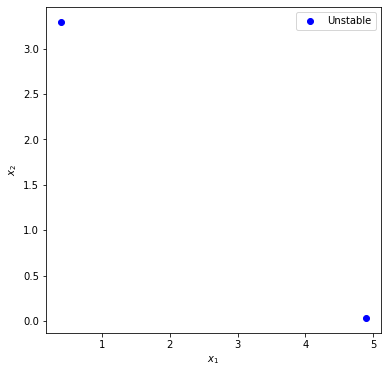

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
for st in np.unique(stabilist):
    idx = np.where(st==stabilist, True, False)
    sc = plt.scatter(fixed_points[idx,0], fixed_points[idx,1], color=colorlist[st], label=labellist[st])
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.legend();
plt.savefig(training_kwargs['figures_path'] + "\\analytical_fixedpoints_noinput.pdf")
# plt.close()

training_kwargs['figures_path']

In [52]:
for i1, p1 in enumerate(fixed_points):
    print(i1, p1)

0 [0.40082112 3.29565823 1.11783997 0.         0.         3.22500245
 0.73115698]
1 [4.88740553 0.03040964 0.55292282 0.         4.13717673 3.31906955
 0.0420305 ]


In [53]:
#check dynamics
#sample trajectories starting at grid points
sampler = qmc.Sobol(d=Nrec, scramble=False)         # sobol sequence as grid
grid = sampler.random_base2(m=8) # random_base2: safely draw  points. This method guarantees the balance properties of the sequence.
grid = grid.reshape((1, -1, Nrec))
hidden = torch.tensor(grid, dtype=torch.float)
hidden_states = sample_hidden_trajs(rnn_model, hidden, maxT=maxT)

#sample trajectories starting around the fixed points to determine connecting orbits (should be enough to do this around unstable fixed points)
distances = np.zeros((number_of_fixed_points, number_of_fixed_points))
for i1, p1 in enumerate(fixed_points):
    save_point = True
    for i2, p2 in enumerate(fixed_points):
        distances[i1, i2] = np.linalg.norm(p1-p2)
min_distance_fxdpnts = np.min(np.where(distances>0., distances, 0.1))
# max_grid = 0.1

all_hidden_stack, grid = sample_trajs_fxdpnts(rnn_model, Nrec, fixed_points, max_grid=min_distance_fxdpnts, Nsteps = 3, maxT=maxT)
#stack trajectories from to samples: grid and fixed points
all_hidden_stack = np.concatenate([all_hidden_stack, hidden_states])
all_hidden_t = np.transpose(all_hidden_stack, axes=(1,0,2))

Text(0, 0.5, 'Activity')

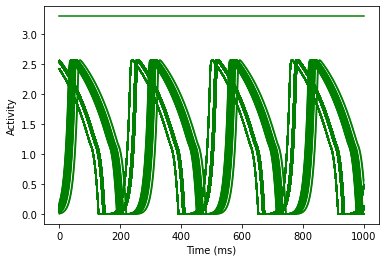

In [56]:
for trial_i in range(500):
    plt.plot(all_hidden_t[-1000:,-trial_i,1], 'g');
# plt.ylim([-.01,2])
plt.xlabel("Time (ms)")
plt.ylabel("Activity")

In [197]:
exp_path = exp_list[0]
exp_path

'C:\\Users\\abel_\\Documents\\Rotations\\CIT\\cit_for_computation\\experiments\\poisson_clicks\\N5\\exp_20_maxepochs200_Nrec5_1657211159'

In [ ]:
conley_path = exp_path + r"\conley_info"
%cd "$conley_path"

if len(RCs)>0:
    log_list = glob.glob(conley_path+"\\*.log")
    # print(log_list)
    for log_name in log_list:
        rc_eigenvalues = []
        created_A = False
        # log_name = log_list[0]
        i=0
        with open(log_name) as file:
            lines = file.readlines()
            lines = [line.rstrip() for line in lines if len(line.rstrip())>0]
            for line in lines:
                # print(line)
                if line.startswith("H_"):
                    # print(line)
                    if line[-1]=="Z":
                        betti = 1
                    else:
                        betti = int(line[-1])
                    A = np.zeros((betti, betti))
                    created_A = True
                if (line.startswith("Dim")) or line.startswith("\tF"):
                    if "\tF" not in line: 
                        continue
                    i+=1
                    # print(i, line)
                    equation_right = line.split('=')[-1]
                    image_strings = equation_right.split('x')[1:]
                    # print(image_strings)
                    for j,image_index in enumerate(image_strings):
                        A[i-1,int(image_index)-1] = 1
            if created_A:
                print(A)
                rci_eigenvalues = np.linalg.eigvals(A)
                print(rci_eigenvalues)

## Recurrent sets and Conley Indices

In [ ]:
disc_durations = []
rc_durations = []
ipci_durations = []

for exp_path in exp_list[:1]:
    print(exp_path)

    idx = exp_path[-10:]
    with open(exp_path + '\\training_kwargs.pickle', 'rb') as handle:
        training_kwargs = pickle.load(handle)

    training_kwargs['exp_path'] = exp_path
    training_kwargs['training_weights_path'] = exp_path+'/training/'
    training_kwargs['figures_path'] = exp_path + '//figures/'
    
    rnn_model = RNNModel(training_kwargs['N_in'], training_kwargs['N_out'], training_kwargs['N_rec'], n_layers=1, transform_function='relu').to(device)
    rnn_model = load_model(rnn_model, training_kwargs)
    rnn_model.eval();
    

    #regular grid
    # grid= np.mgrid[tuple(slice(0, max_grid, step) for _ in range(Nrec))].reshape((1, int((Ngrid)**Nrec), Nrec))

    # sobol sequence
    sampler = qmc.Sobol(d=Nrec, scramble=False)
    grid = sampler.random_base2(m=10) # random_base2: safely draw  points. This method guarantees the balance properties of the sequence.
    grid = grid.reshape((1, -1, Nrec))*1

    maxT = 5000
    step = 10
    max_grid = 20
    Ngrid = int(max_grid/step)

    hidden = torch.tensor(grid, dtype=torch.float)
    batch_size = grid.shape[1] #int((Ngrid)**Nrec)
    inputs =  torch.zeros((batch_size, maxT, 2), dtype=torch.float)
    # inputs[:, :, 0] = 
    hidden_states, hidden_last = rnn_model.rnn(inputs, hidden)
    hidden_states = hidden_states.detach().numpy()
    hidden_states.shape
    
    for i in range(1):
        plt.plot(hidden_states[:,-10:,i].T);

    #time discretization:
    start_time = time.time()
    #Make combinatorial dynamical system from the data
    N=Nrec
    t_len = maxT
    time_shift = 1900
    data_legth = t_len - time_shift
    data_length_list = [t_len] * batch_size
    hidden_states_t = np.transpose(hidden_states,axes=(1,0,2)) #np.reshape(hidden_states, (batch_size, -1, Nrec))
    hdatas = np.array(hidden_states_t[time_shift:,:,:])#.reshape(-1,N) #npa[shift:,1:]
    expnbin = 3
    nbins = 2**expnbin
    delta = 1/nbins
    # print(delta)
    cds = cf.Combinatorial_Dynamical_System(delta)
    cds.get_cubesandgraph(hdatas[:,:], nbins, data_length_list, calc_matrix=True)
    duration = time.time() - start_time
    disc_durations.append(duration)
    
    #time Tarjan:
    start_time = time.time()
    RCs = cds.get_recurrent_components(includeselfedges=True)
    # print("Number of cyclic strongly connected components: ", len(RCs))
    duration = time.time() - start_time
    rc_durations.append(duration)
    
    #make dir for conley
    conley_path = exp_path + r"\conley_info"
    makedirs(conley_path)
    %cd "$conley_path"

    #time index pair + Conley index:
    start_time = time.time()
    get_indexpair_and_conleyindex(cds, RCs)
    duration = time.time() - start_time
    ipci_durations.append(duration)

In [ ]:
# disc_durations
# rc_durations
# ipci_durations

plt.hist(disc_durations)
plt.hist(rc_durations)
plt.hist(ipci_durations)

In [ ]:
# all_hidden_t = all_hidden.reshape((maxT,number_of_fixed_points*grid.shape[1] ,N))
start_time = time.time()
all_hidden_t = np.transpose(all_hidden_stack, axes=(1,0,2))
batch_size = all_hidden_t.shape[0]
t_len = maxT
time_shift = 4000
time_max = maxT
data_legth = time_max - time_shift
data_length_list = [data_legth] * batch_size
# hidden_states_t = np.transpose(all_hidden_t,axes=(1,0,2)) #np.reshape(hidden_states, (batch_size, -1, Nrec))
# hdatas = np.array(all_hidden_t[time_shift:,:,:]).reshape(-1,N) #npa[shift:,1:]
hdatas = np.array(all_hidden_t[time_shift:time_max,:,:])#.reshape(-1,N) #npa[shift:,1:]

expnbin = 4
nbins = 2**expnbin
delta = 1/nbins
cds = cf.Combinatorial_Dynamical_System(delta)
cds.get_cubesandgraph(hdatas, nbins, data_length_list, calc_matrix=True, minval=minval, maxval=maxval)

RCs = cds.get_recurrent_components(includeselfedges=False)
len(RCs)
duration = time.time()-start_time
duration

In [ ]:
#get cubes of fixed points:
time_shift = 0
time_max = 10
hdatas = np.array(all_hidden_t[time_shift:time_max,:,:])#.reshape(-1,N) =

cds_fxd = cf.Combinatorial_Dynamical_System(delta)
cds_fxd.get_cubesandgraph(hdatas, nbins, data_length_list, calc_matrix=True, minval=minval, maxval=maxval)

RCs_fxd = cds_fxd.get_recurrent_components(includeselfedges=True)
len(RCs_fxd) #==number_of_fixed_points

In [ ]:
hdatas = np.array(all_hidden_t)
cds_full = cf.Combinatorial_Dynamical_System(delta)
cds_full.get_cubesandgraph(hdatas, nbins, data_length_list, calc_matrix=True, minval=minval, maxval=maxval)

In [ ]:
#from repellers (first 
start_time = time.time()
connection_matrix = np.zeros((len(RCs_fxd)+len(RCs),len(RCs_fxd)+len(RCs))) #has all path information

for i in range(len(RCs_fxd)):
    for j in range(len(RCs_fxd)):
        if i!=j:
            try:
                pathij = nx.shortest_path(cds_full.G, source=RCs_fxd[i][0], target=RCs_fxd[j][0])                # print(pathij)
                connection_matrix[i,j]=1
            except nx.NetworkXNoPath:
                0
    for j in range(len(RCs)):
            try:
                pathij = nx.shortest_path(cds_full.G, source=RCs_fxd[i][0], target=RCs[j][0])                # print(pathij)
                connection_matrix[i,len(RCs_fxd)+j]=1
            except nx.NetworkXNoPath:
                0
                
connection_matrix #if there is a non-zero entry at [i,j] then there is a path from i to j

# nx.draw(cds.G)

duration = time.time()-start_time
duration

connection_matrix

In [ ]:
log_list = glob.glob(conley_path+"\\*.log")
log_name = log_list[0]
i=0
with open(log_name) as file:
    lines = file.readlines()
    lines = [line.rstrip() for line in lines if len(line.rstrip())>0]
    for line in lines:
        # print(line)
        if line.startswith("H_"):
            # print(line)
            betti = int(line[-1])
            A = np.zeros((betti, betti))
        if (line.startswith("Dim")) or line.startswith("\tF"):
            if "\tF" not in line: 
                continue
            i+=1
            # print(i, line)
            equation_right = line.split('=')[-1]
            image_strings = equation_right.split('x')[1:]
            # print(image_strings)
            for j,image_index in enumerate(image_strings):
                A[i-1,int(image_index)-1] = 1
            
#first:    homology of the graph of F over the ring of integers        
# second:  homology of Y over the ring of integers

In [ ]:
A

In [ ]:
np.log10((2**4)**7)